# Via Data Challenge
### Yuan Huang
---

In [66]:
from IPython.display import HTML

HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form  action="javascript:code_toggle()">
<input style="font-size: 25px; padding: 10px" type="submit" value="Click me to hide/show all raw code in the report"></form>''')

## Outline

Via is considering expanding its service area to include Astoria, Queens. We are trying to find the optimal way to launch this expansion.

We are using the NYC taxi data from the period before July 2016 (described and available here: http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml, also available either through BiqQuery https://bigquery.cloud.google.com/table/imjasonh-storage:nyctaxi.trip_data, or in smaller samples from http://www.andresmh.com/nyctaxitrips/), to answer the following questions:

Analysis Questions:

1. How would we assess the efficiency of aggregating rides within Astoria? From Astoria to Manhattan? From LaGuardia airport, through Astoria, to Manhattan and back?

2. How does this compare to our current area of service (e.g. the Upper East Side)?

3. Would we provide rides only within Astoria for this new service or also between Astoria and Manhattan? Why?

4. Would we launch Astoria service during all our hours of operation (24/7) or only for certain hours? If so - which hours?

Statistical Questions:

5. If given a metric for efficiency (assume we don't know how it's calculated), how to determine whether a specific zone is more efficient than the rest of the city? How would we determine why it’s more efficient?

6. How would we compare the distributions of intra-city trip prices between two different cities? How would we test whether any differences we find are explained by distance and duration?

The report will be organized in this way:

  1. [Exploring the Data](#chapter-1)
      1. [Data Inspection and Preprocessing](#chapter-1a)
      2. [Exploratory Data Visualization](#chapter-1b)
      
  2. [Expansion to Astoria](#chapter-2)
      1. [How is the efficiency in this area? How does it compare to current areas of service?](#chapter-2a)
      2. [Shall we provide rides only within Astoria or also between Astoria and Manhattan?](#chapter-2b)
      3. [Which hours shall we launch Astoria services?](#chapter-2c)
      
  3. [Further Insights](#chapter-3)
      1. [Improve efficiency by recommending next ride for driver](#chapter-3a)
      2. [Improve efficiency by ride-sharing](#chapter-3b)
      
  4. [Statistical Questions](#chapter-4)
      1. [How to determine whether a zone is more efficient? How to determine why it's more efficient?](#chapter-4a)
      2. [How to compare distributions of trip prices between different cities? How to test whether differences are explained by distance and duration?](#chapter-4b)
      
  5. [Conclusions and Insights](#chapter-5)

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import pickle

from sqlalchemy import create_engine
from sqlalchemy.sql import text
import datetime as dt
from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

DEBUG = False

## 1. Exploring the Data <a id="chapter-1"></a>

### A) Data Inspection and Preprocessing<a id="chapter-1a"></a>
The data used in this report were collected by the New York City Taxi and Limousine Commission (NYC TLC) on the trip by trip basis and downloaded from http://www.andresmh.com/nyctaxitrips/. This data set recorded all the taxi trips in New York City from January, 2013 to December, 2013. To understand the stable taxi ride pattern, I will be focusing on the data recored in August, 2013 for one month, which contains more than 12,000,000 rides. 

The data is stored in two seperate tables with the following schema:

** Table 1: trip_data**

|columns| description |
|--------------|---|
| medallion    | Medallion license id for taxi.  |
| hack_license | The taxi driver license id. |
| vendor_id    | A code indicating the TPEP provider that provided the record.   |
| rate_code    | The final rate code in effect at the end of the trip.\* |
| store_and_fwd_flag | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor. |
| pickup_datetime    | The date and time when the meter was engaged.   |
| dropoff_datetime    | The date and time when the meter was disengaged.   |
| passenger_count    | The number of passengers in the vehicle. Driver entered value. |
| trip_time_in_secs    | The trip time in seconds. |
| trip_distance   |  The elapsed trip distance in miles reported by the taximeter  |
| pickup_longitude    | Longitude where the meter was engaged.  |
| pickup_latitude    | Latitude where the meter was engaged.  |
| dropoff_longitude     | Longitude where the meter was disengaged.  |
| dropoff_latitude    |  Lattitude where the meter was disengaged. |

\* rate code:

1 = Standard rate; 2 = JFK; 3 = Newark; 4 = Nassau or Westchester; 5 = Negotiated fare; 6 = Group ride

**Table 2: trip_fare**

|columns| description |
|--------------|---|
| medallion    | Medallion license id for the taxi.  |
| hack_license | The taxi driver license id.  |
| vendor_id    | A code indicating the TPEP provider that provided the record.  |
| pickup_datetime    | The date and time when the meter was engaged.  |
| payment_type  | A numeric code signifying how the passenger paid for the trip.\*  |
| fare_amount  | The time-and-distance fare calculated by the meter  |
| surcharge  |  Miscellaneous extras and surcharges. Currently, this only includes the \$0.50 and \$1 rush hour and overnight charges. |
|  mta_tax | \$0.50 MTA tax that is automatically triggered based on the metered rate in use.  |
|  tip_amount    | Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.  |
|  tolls_amount    | Total amount of all tolls paid in trip.   |
|  total_amount    | The total amount charged to passengers. Does not include cash tips.  |

\* payment type code:

1 = Credit card; 2 = Cash; 3 = No charge; 4 = Dispute; 5 = Unknown; 6 = Voided trip

#### Handling Missing and wrong values in the dataset

During the inspection of the two tables, I found there are several thousands of rows with missing values or wrong values. I decided to drop all these rows since the number of rows are very small compared to the total amount of data. 

1. Passenger count:
There are rides with 0 or 208 passengers which should be wrong values entered accidentally by drivers.
2. Trip time: Trip time can not be negative or longer than one day (86400 seconds).
3. Trip distance: Distance longer than 100 miles are unreasonably high for taxi rides in NYC.
4. fare: The payment amount for all kinds of fees and fare should not be nagative.

After the data cleaning process, there are 12,303,170 rides in the dataset during August, 2013.

#### Finding the corresponding zone for pickup and dropoff coordinates

For future analysis, we need to find out the taxi zone and corresponding boroughs for each pickup and dropoff location. A shapefile containing the boundaries for the taxi zones and the TLC taxi zone location IDs, location names and corresponding boroughs for each ID can be found  on http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml. 

With the given shapefile, I wrote a script (./preprocessing_add_locationID_parallel.py) to find out the pickup and dropoff location ID for all the rides in the dataset, and save them as two new columns "pickup_LocationID" and "dropoff_LocationID".

In [20]:
zones = pd.read_csv("./taxi_zones/taxi_zone_lookup.csv")

#The taxi zones that each borough contains
Manhattan_zones = zones[zones.Borough=="Manhattan"]["LocationID"].tolist()
Queens_zones = zones[zones.Borough=="Queens"]["LocationID"].tolist()
Bronx_zones = zones[zones.Borough=="Bronx"]["LocationID"].tolist()
Brooklyn_zones = zones[zones.Borough=="Brooklyn"]["LocationID"].tolist()
Staten_Island_zones = zones[zones.Borough=="Staten Island"]["LocationID"].tolist()
EWR_zones = zones[zones.Borough=="EWR"]["LocationID"].tolist()

#The regions that we are particularly interested in: Astoria, Laguardia, and Upper East Side
Astoria_zones = zones[[row in ["Astoria", "Old Astoria", "Astoria Park"] 
                       for row in zones.Zone]]["LocationID"].tolist()
Laguardia_zones = zones[zones.Zone == "LaGuardia Airport"]["LocationID"].tolist()

Upper_east_zones = zones[[row in ["Upper East Side North", "Upper East Side South"] 
                          for row in zones.Zone]]["LocationID"].tolist()

#Steinway_zones = zones[zones.Zone == "Steinway"]["LocationID"].tolist()
#Jackson_zones = zones[zones.Zone == "Jackson Heights"]["LocationID"].tolist()
#Woodside_zones = zones[zones.Zone == "Woodside"]["LocationID"].tolist()

In [21]:
def region(location_id):
    if location_id in Astoria_zones:
        return "AST"
    elif location_id in Laguardia_zones:
        return "LAG"
    elif location_id in Upper_east_zones:
        return "UES"
    #elif location_id in Steinway_zones:
    #    return "STW"
    #elif location_id in Jackson_zones:
    #    return "JKH"
    #elif location_id in Woodside_zones:
    #    return "WDS"
    else:
        return

In [22]:
def borough(location_id):
    if location_id in Manhattan_zones:
        return "MAN"
    elif location_id in EWR_zones:
        return "EWR"
    elif location_id in Queens_zones:
        return "QUE"
    elif location_id in Bronx_zones:
        return "BRX"
    elif location_id in Brooklyn_zones:
        return "BKL"
    elif location_id in Staten_Island_zones:
        return "STI"
    else:
        return

#### Merging trip_data and trip_fare and Loading data in Sqlite database
After preprocessing and dropping unnecessary columns, I merge the trip_data and trip_fare into a single table and load it into a sqlite db.

In [23]:
disk_engine = create_engine('sqlite:///trip_data_2013.db')

### B) Exploratory Data Visualization<a id="chapter-1b"></a>

The number of pickups during different hour of the day in all the zones of NYC:

![alt text](./img/pickup.gif "Title")

The number of dropoffs during different hour of the day in all the zones of NYC:

![alt text](./img/dropoff.gif "Title")

## 2. Expansion to Astoria <a id="chapter-2"></a>

### A) How is the efficiency within Astoria, between Astoria and Manhattan, from LaGuardia airport through Astoria to Manhattan and back? How does it compare to current areas of service? <a id="chapter-2a"></a>

The efficiency of rides within a certain region or along a certain route can be evaluated in several different aspects. From the taxi drivers' point of view, the most important metric is the amount of money earned per unit time; while for passengers, the distance travelled per unit time will be more important. As for the whole taxi system, using less drivers to provide services for more passengers to reach their destinations in shorter time is the ultimate goal. 

Therefore, I considered several different factors to access the efficiency of rides:

  - distance travelled per unit time 
  - fare earned by the driver per unit time 
  - average number of passengers per ride
  - the average waiting time for drivers to find the next passengers after their last ride 
    
In order to compare the efficieny between Astoria and the current area of service (in this report I choose Upper East Side as an example), I calcuated the efficiency metrics for both areas in parallel, including rides within the area of interest, between LaGuardia Airport and this area, and between all other zones in Manhattan and this area.

#### Distance traveled / fare earned per minute, number of passengers per ride

The following plots compare the average trip time/distance, distance/fare per minute, and number of passengers for Astoria services and the current Upper Ease Side services. From the analysis, we can see that:

  * The average fare earned per minute and average number of passengers are very similar between those two areas
  * The distance traveled per minute for rides between Astoria and Manhattan are much higher than Upper East Side, while the rides from Astoria to LaGuardia airport have relatively lower distance traveled per minute compared to Upper East Side.

In [24]:
def query_regional_rides(region_zones):
    # aggregating the rides within the specified region, 
    #                       between this region and LaGuardia, 
    #                       between this region and Manhattan
    
    query_region = '''SELECT * 
                       FROM ( SELECT *, 
                           CASE WHEN pickup_LocationID IN ({region_ids}) 
                             AND dropoff_LocationID IN ({region_ids}) THEN "within" 
                           WHEN pickup_LocationID IN ({region_ids}) 
                             AND dropoff_LocationID IN ({laguardia_ids}) THEN "from_lag" 
                           WHEN pickup_LocationID IN ({laguardia_ids}) 
                             AND dropoff_LocationID IN ({region_ids}) THEN "to_lag" 
                           WHEN pickup_LocationID IN ({manhattan_ids}) 
                             AND dropoff_LocationID IN ({region_ids}) THEN "from_man"
                           WHEN pickup_LocationID IN ({region_ids})
                             AND dropoff_LocationID IN ({manhattan_ids}) THEN "to_man" 
                           ELSE NULL 
                           END AS zones 
                           FROM trip_data )
                       WHERE zones IS NOT NULL '''
    f = {"region_ids": ",".join([str(i) for i in region_zones]), 
        "laguardia_ids": ",".join([str(i) for i in Laguardia_zones]), 
         "manhattan_ids": ",".join([str(i) for i in Manhattan_zones])}

    return pd.read_sql_query(query_region.format(**f), disk_engine)

In [ ]:
df_Astoria = query_regional_rides(Astoria_zones)
if DEBUG:
    print "Number of Taxi Rides Between 2013-08-01 and 2013-08-31"
    print "within Astoria:                    ", len(df_Astoria[df_Astoria.zones=="within"])
    print "from Astoria to LaGuardia Airport: ", len(df_Astoria[df_Astoria.zones=="to_lag"])
    print "from LaGuardia Airport to Astoria: ", len(df_Astoria[df_Astoria.zones=="from_lag"])
    print "from Astoria to Manhattan:         ", len(df_Astoria[df_Astoria.zones=="to_man"])
    print "from Manhattan to Astoria:         ", len(df_Astoria[df_Astoria.zones=="from_man"])

df_Upper = query_regional_rides(Upper_east_zones)
if DEBUG:
    print "Number of Taxi Rides Between 2013-08-01 and 2013-08-31"
    print "within Upper East Side:                    ", len(df_Upper[df_Upper.zones=="within"])
    print "from Upper East Side to LaGuardia Airport: ", len(df_Upper[df_Upper.zones=="to_lag"])
    print "from LaGuardia Airport to Upper East Side: ", len(df_Upper[df_Upper.zones=="from_lag"])
    print "from Upper East Side to Manhattan:         ", len(df_Upper[df_Upper.zones=="to_man"])
    print "from Manhattan to Upper East Side:         ", len(df_Upper[df_Upper.zones=="from_man"])

df_Astoria["region"] = "AST"
df_Upper["region"] = "UES"
df_rides = pd.concat([df_Astoria, df_Upper], axis=0)

agg_rides = df_rides[['region', 'zones', 'passenger_count', 'trip_distance', 'trip_time', 'fare_amount']] \
                        .groupby(['zones', 'region']).mean().reset_index()

agg_rides["fare_per_minute"] = agg_rides["fare_amount"]/agg_rides["trip_time"]*60.0
agg_rides["dist_per_minute"] = agg_rides["trip_distance"]/agg_rides["trip_time"]*60.0

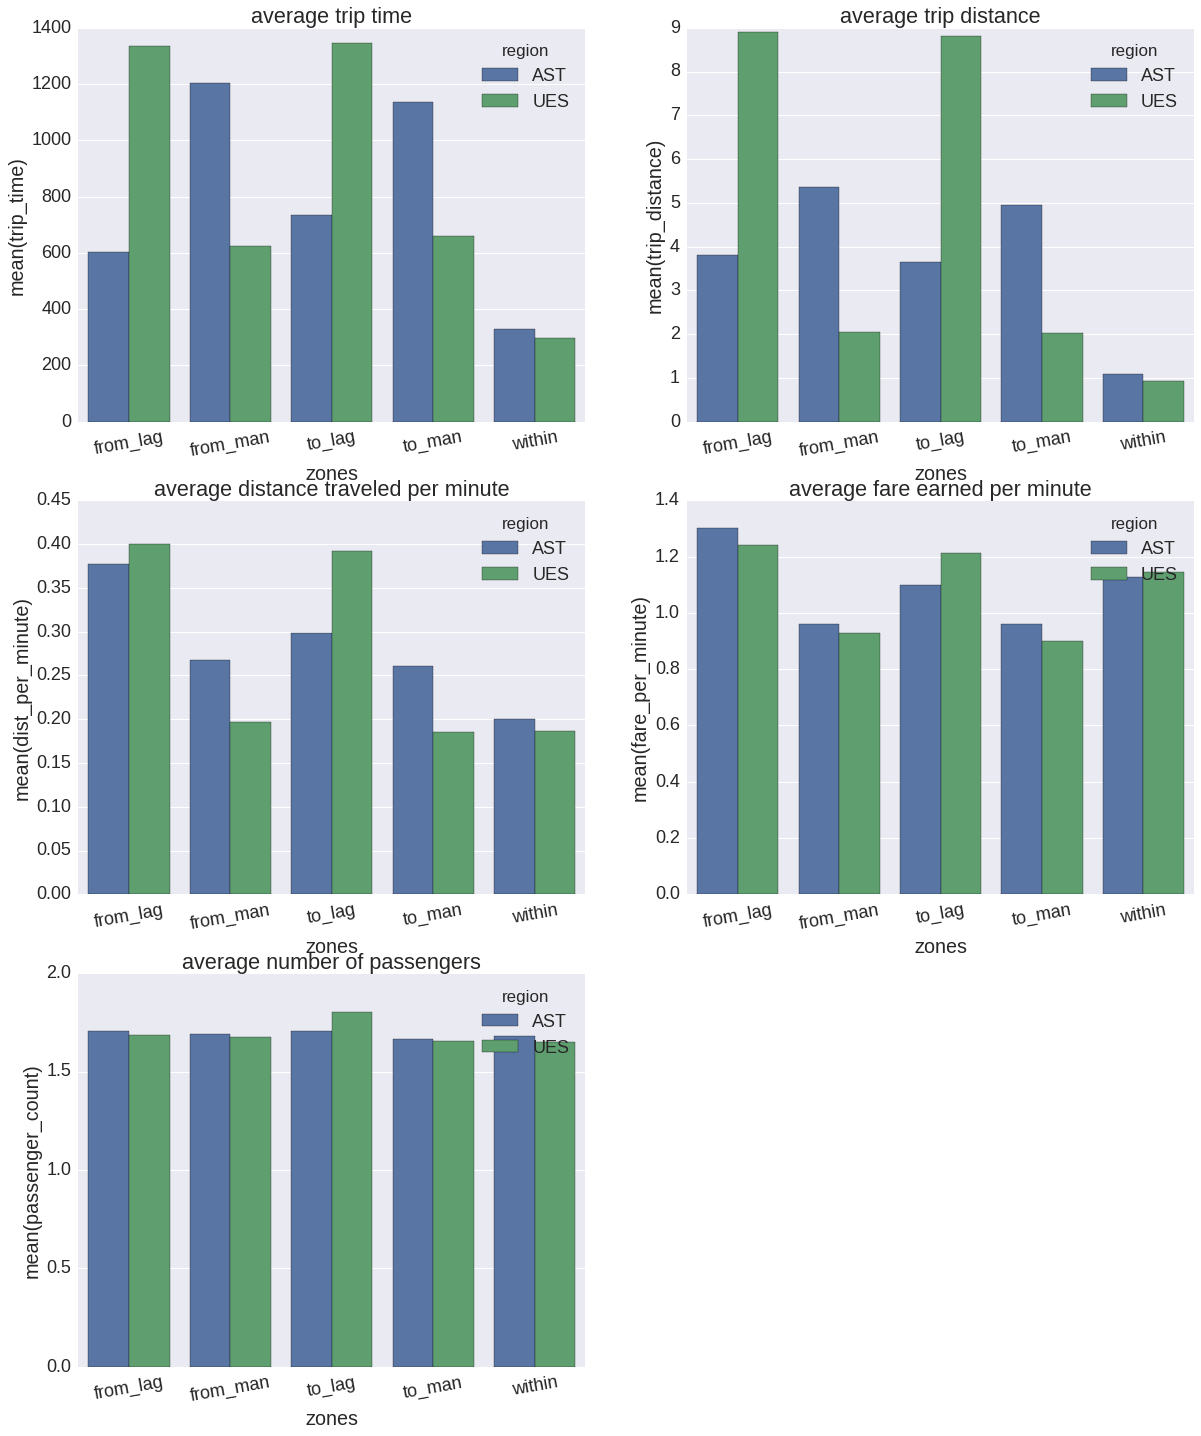

In [10]:
def plot_bar(df, x_cols, y_cols, titles):
    n_y = len(titles)/2 + 1
    plt.figure(figsize=(20,n_y*8))
    for i in range(len(titles)):
        plt.subplot(n_y, 2, i+1)
        sns.barplot(x=x_cols[i],y=y_cols[i],data=df, hue='region')
        plt.xticks(rotation=10)
        plt.title(titles[i])

y_cols = ["trip_time", "trip_distance", "dist_per_minute", "fare_per_minute", "passenger_count"]
x_cols = ["zones"]*len(y_cols)
titles = ["average trip time", "average trip distance", "average distance traveled per minute",
          "average fare earned per minute", "average number of passengers"]

sns.set(font_scale=1.8)
plot_bar(agg_rides, x_cols, y_cols, titles)

#### Waiting time for drivers to find their next passengers

The last metric efficiency I calculated is the average time for taxi drivers to find their next passengers after dropping the previous passengers off in a certain area. To be more specific, I wants to find out all the unique taxis (according to their medallion ids) that dropped off in Astoria, then find out the time difference between this ride's dropoff time and the next pickup time for the same taxi. I ignored the case when duration exceeds 6 hours since this might mean the driver has finished his/her shift for the day. In order to do this, I wrote script to perform parallel calculations to get results faster.

Let's take a look at the results for the average time (minutes) for drivers to find their next trip in Astoria, LaGuardia Airport, and Upper East Side during different hours in weekdays and weekends.

In [38]:
df_wait = pd.read_csv("./wait_time/august_wait_time.csv")
df_wait["region"] = df_wait["dropoff_LocationID"].apply(region)
agg_wait = df_wait[["wait_time", "region"]].groupby("region").describe() \
                                            .stack(level=1).reset_index()
agg_wait.columns = ['region', 'statistics', 'wait_time']

In [9]:
#sns.set(font_scale=1.5)
#sns.barplot(x='region',y='wait_time',
#            data=agg_wait[agg_wait.statistics.isin(["mean", "50%"])], 
#            hue='statistics')
#plt.title("waiting time when dropping off at different regions")

In [39]:
df_wait["hour"] = df_wait["dropoff_datetime"].apply(lambda x: pd.to_datetime(x).hour)
df_wait.head()
df_wait["weekday"] = df_wait["dropoff_datetime"].apply(lambda x: pd.to_datetime(x).weekday())
df_wait["weekday"] = df_wait["weekday"].apply(lambda x: "weekday" if x<5 else "weekend")
agg_wait_by_hour = df_wait[["wait_time", "region", "weekday", "hour"]] \
                    .groupby(["region", "weekday", "hour"]).median().reset_index()

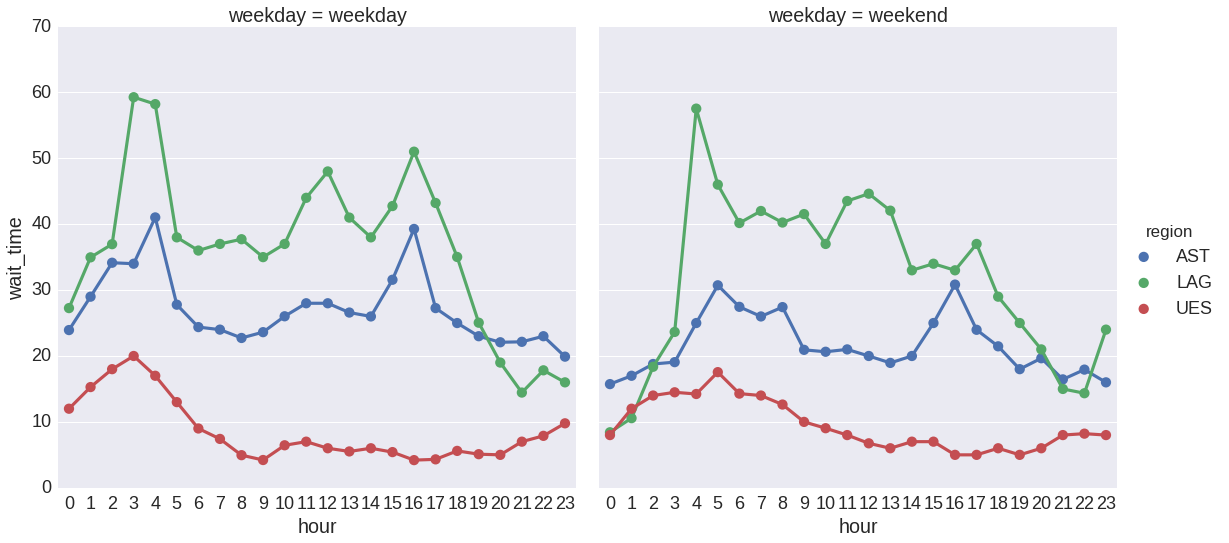

In [90]:
sns.set(font_scale=1.8)
g=sns.factorplot(x='hour',y='wait_time', col="weekday",
               data=agg_wait_by_hour,
               hue='region',  size=8)

In general, the waiting time in Astoria is much longer than Upper East Side, especially during certain hours of the day (1am-5am, 3pm-6pm). But on the other hand, compared to LaGuardia Airport, the waiting time in Astoria is much shorter. And since Astoria is rather close to LaGuardia (15min of driving), this indicates that opening the Astoria service could provide a chance for the drivers to drive from LaGuardia to Astoria to seek for their next clients.

### B) Shall we provide rides only within Astoria or also between Astoria and Manhattan? Why? <a id="chapter-2b"></a>

**Conclusion**: If we are going to launch the new services for Astoria, we should provide rides both within Astoria and between Astoria and Manhattan. The rides between Astoria and Manhattan will be an important part of our business.

The following chart shows the number of rides per hour within Astoria, between Astoria and Manhattan, and between Astoria and LaGuardia Airport. We can definitely see a large demand in the market for rides between Astoria and Manhattan, especially from Manhattan to Astoria. The number of rides within Astoria is much smaller since this is a small residential area. 

In [25]:
df_Astoria = query_regional_rides(Astoria_zones)
df_Astoria["region"] = "AST"
df_Upper_east = query_regional_rides(Upper_east_zones)
df_Upper_east["region"] = "UES"

count_rides= df_Astoria[["region", "zones", "index"]].groupby(["region", "zones"]).count().reset_index()

count_rides.columns = ["region", "zones", "number_of_rides"]
count_rides["number_of_rides"] = count_rides["number_of_rides"]/31.0/24.0

Average number of rides per hour within Astoria, between Astoria 
             and Manhattan, and between Astoria and LaGuardia


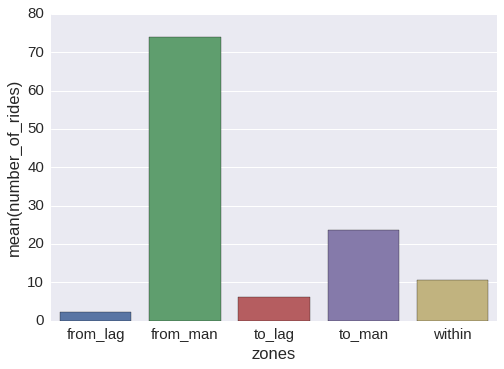

In [95]:
sns.set(font_scale=1.5)
sns.barplot(x='zones',y='number_of_rides',
            data=count_rides[count_rides.region=="AST"])
print("Average number of rides per hour within Astoria, between Astoria \n \
            and Manhattan, and between Astoria and LaGuardia")

There are a lot of people going from Astoria to Manhattan and from Manhattan to Astoria everyday. Moreover, a large portion of those rides are happening during a short period of time (which can be seen from the plots in the next [session](#chapter-2c). This means there are a lot of space for ride-sharing business to grow in these areas. By looking for passengers having similar pickup and dropoff locations and suggesting ride-sharing, we can provide those passengers more affordable and efficient transportation services.

### C) Which hours shall we launch Astoria services? <a id="chapter-2c"></a>

To decide which hours we should launch our new services, we need to look at demands in the market at different hours of the day, on weekdays and weekends. As discussed above, the services within Astoria and between Astoria and Manhattan have very different features and we need to look at them seperately. 

** The summary of my suggestions ** are:
  * For within Astoria services: only provide normal hour services (6pm-8pm). 
  * For rides from Manhattan to Astoria: provide all-day (24/7) services but need to adjust the number of drivers for the service according to different time of the day.
  * For rides from Astoria to Manhattan: provide all-day (24/7) services.  
  
The reasons for the suggestions:

For rides within Astoria, the average number of rides per hour at different time of the day have a relatively flat distribution, with a peak during late night on both weekday and weekends. The reason for these peaks might be there's no subway services during this period of time. However if we want to provide services at late night, the flat rate we need to pay the drivers will also increase. Overall, the number of rides per hour within Astoria is much lower compared to our current service (e.g. Upper East Side), making the service within this area not that likely to bring much profit.

In [66]:
df_Astoria["hour"] = df_Astoria["pickup_datetime"].apply(lambda x: pd.to_datetime(x).hour)
df_Astoria["weekday"] = df_Astoria["pickup_datetime"].apply(lambda x: pd.to_datetime(x).weekday())

df_Astoria.weekday = df_Astoria.weekday.apply(lambda x: "weekday" if x<5 else "weekend")

hourly_count = df_Astoria[["zones", "index", "hour", "weekday"]].groupby(["hour", "zones", "weekday"]) \
                        .count().reset_index()
if DEBUG:
    hourly_count.head()

hourly_count.columns = ["hour", "zones", "weekday", "number_of_rides"]
# number of weekdays in 2013 august: 22
hourly_count.loc[hourly_count.weekday=="weekday","number_of_rides"] = \
                    hourly_count.loc[hourly_count.weekday=="weekday","number_of_rides"]/22.0
# number of weekends in 2013 sugust: 9
hourly_count.loc[hourly_count.weekday=="weekend","number_of_rides"] = \
                    hourly_count.loc[hourly_count.weekday=="weekend","number_of_rides"]/9.0

Average number of rides per hour within Astoria


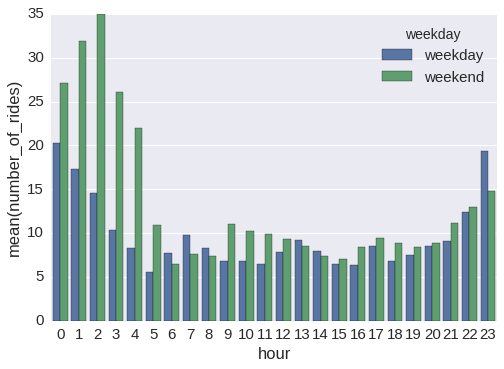

In [96]:
sns.set(font_scale=1.5)
g = sns.barplot(x='hour',y='number_of_rides',
            data=hourly_count[hourly_count.zones=="within"],
            hue="weekday")
print("Average number of rides per hour within Astoria")

The rides from Manhattan to Astoria are also mostly happening during the evening (6pm-5am), while during the day there are fewer needs for the service. One issue we need to consider is when drivers take passengers to Astoria, they need to spend long time (around 20-30 minutes) to find the next business. Therefore we need to fine-tune the number of drivers for this service and find better strategies for them to find their next rides. (This will be further discussed in next [chapter](#chapter-3)). Overall, considering that there are a lot of need of going Manhattan to Astoria, I suggest to launch the service 24/7.

Average number of rides per hour from Manhattan to Astoria


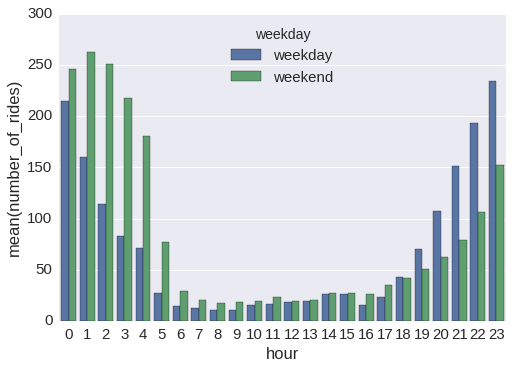

In [97]:
sns.set(font_scale=1.5)
g = sns.barplot(x='hour',y='number_of_rides',
            data=hourly_count[hourly_count.zones=="from_man"],
            hue="weekday")
print("Average number of rides per hour from Manhattan to Astoria")

The rides from Astoria to Manhattan have a much flatter distribution. Considering that drivers in Manhattan are very easy to find business, I suggest to launch the service from Astoria to Manhattan all-day (24/7).

Average number of rides per hour from Astoria to Manhattan


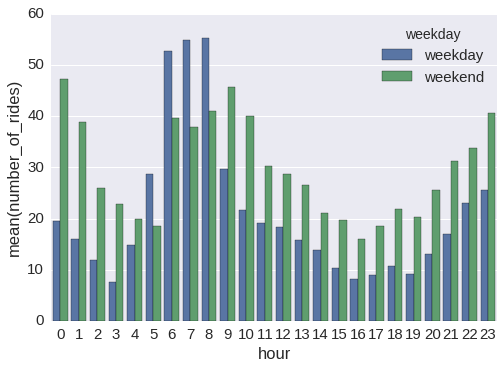

In [98]:
sns.set(font_scale=1.5)
g = sns.barplot(x='hour',y='number_of_rides',
            data=hourly_count[hourly_count.zones=="to_man"],
            hue="weekday")
print("Average number of rides per hour from Astoria to Manhattan")

## 3. Further Insights <a id="chapter-3"></a>

### A) Improve efficiency by recommending next ride for driver <a id="chapter-3a"></a>

As I mentioned above, the waiting time for taxi driver to find the next ride varies from region to region. If we can use algorithms to help each driver to find their next business, we will save a lot of time for the driver and boost the efficiency for the whole taxi system. 

#### Find the next ride in the area that driver dropped off

In this session I will use some proof-of-principle algorithms to try to recommend the next ride for drivers and see how much this will reduce driver's average waiting time. 

The idea of this algorithm is: After the driver dropped off their last passengers in a certain area (e.g. Astoria), the algorithm will search in the region within 3km of the dropoff location, and find the rides that start within 5min after the dropoff time. From all the rides found, we pick the ride with nearest pickup location to recommend to this driver.

Based on this algorithm, we can reduce the average waiting time for drivers from more than 20 minutes to less than 5 minutes in Astoria. While for Upper East Side, since the waiting time is already very short, there's not much space to be further optimized. 

In [35]:
AVG_SPEED = 0.2

def get_time(row):
    travel_time = row.next_pickup_dist/AVG_SPEED
    if travel_time > row.opt_wait_time:
        return travel_time
    else:
        return row.opt_wait_time

def get_recommend_table(zone_name):
    
    df_recommend = pd.read_csv("./recommend_next_ride/{0}/{0}_recommend_next_rides_total.csv" \
                               .format(zone_name))

    del df_recommend["Unnamed: 0"]
    del df_recommend["Unnamed: 0.1"] 
    del df_recommend["Unnamed: 0.1.1"]

    df_recommend["rec_wait_time"] = df_recommend.apply(lambda x: get_time(x), axis=1)
    df_recommend["region"] = zone_name
    return df_recommend

In [36]:
astoria_recommend = get_recommend_table("AST")
laguardia_recommend = get_recommend_table("LAG")
upper_east_recommend = get_recommend_table("UES")

df_rec_wait = pd.concat([astoria_recommend, laguardia_recommend, upper_east_recommend], axis = 0)
agg_rec_wait = df_rec_wait[["rec_wait_time", "region"]].groupby("region").describe().stack(level=1).reset_index()
agg_rec_wait.columns = ['region', 'statistics', 'wait_time']

In [40]:
agg_wait["status"] = "original"
agg_rec_wait["status"] = "optimized"
compare = pd.concat([agg_wait, agg_rec_wait], axis=0)
if DEBUG:
    compare.head()

comparisons of the median waiting time between the original case and after recommendations


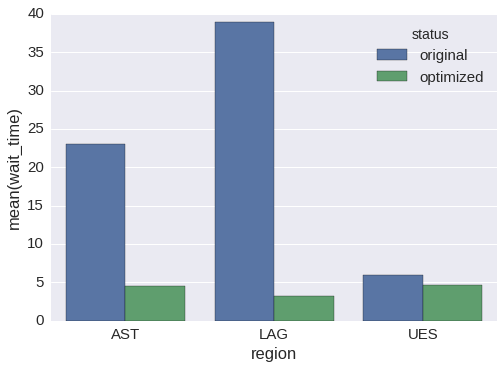

In [41]:
sns.set(font_scale=1.5)
g = sns.barplot(x='region',y='wait_time',
            data=compare[compare.statistics=="50%"], 
            hue='status')
print("comparisons of the median waiting time between the original case and after recommendations")

#### Recommend the driver to go to nearby areas with larger demand

When we decide whether we should launch the new services from Manhattan to Astoria, I have some concerns that the drivers come into Astoria may have some difficulty finding their next business because there's not much demand in that area. But while looking at the number of rides coming in and going out, I made another interesting finding between Astoria and LaGuardia Airport that may give us some insight about how to solve this problem.

From the following line charts, there's an interesting pattern: When there are a lot of rides coming in Astoria, there are also a large demand of rides going out of LaGuardia airport.

In [26]:
def query_flow(zones, is_in):
    if is_in:
        # query all the rides coming in to the regions
        query_rides = '''SELECT pickup_datetime, dropoff_datetime, pickup_LocationID, pickup_long, pickup_lat,
                                dropoff_LocationID, dropoff_long, dropoff_lat
                         FROM trip_data
                         WHERE dropoff_LocationID IN ({zone_ids})'''
    else:
        # query all the rides coming out of the regions
        query_rides = '''SELECT pickup_datetime, dropoff_datetime, pickup_LocationID, pickup_long, pickup_lat,
                                dropoff_LocationID, dropoff_long, dropoff_lat
                         FROM trip_data
                         WHERE pickup_LocationID IN ({zone_ids})'''
    f = {"zone_ids": ",".join([str(i) for i in zones])}
    return pd.read_sql_query(query_rides.format(**f), disk_engine)

In [27]:
df_flow_in = query_flow(Astoria_zones+Laguardia_zones+Upper_east_zones, is_in=True)
if DEBUG:
    print "Number of rides: ", len(df_flow_in)
    df_flow_in.head()

df_flow_out = query_flow(Astoria_zones+Laguardia_zones+Upper_east_zones, is_in=False)
if DEBUG:
    print "Number of rides: ", len(df_flow_out)
    df_flow_out.head()

In [28]:
df_flow_in["hour"] = df_flow_in["dropoff_datetime"].apply(lambda x: pd.to_datetime(x).hour)
df_flow_in["weekday"] = df_flow_in["dropoff_datetime"].apply(lambda x: pd.to_datetime(x).weekday())
df_flow_in["weekday"] = df_flow_in["weekday"].apply(lambda x: "weekday" if x<5 else "weekend")
df_flow_in["region"] = df_flow_in["dropoff_LocationID"].apply(region)

agg_flow_in = df_flow_in[['region', 'weekday', 'hour', 'dropoff_datetime']] \
                .groupby(['region', 'weekday', 'hour'], as_index=False).count()
agg_flow_in.columns = ["region", "weekday", "hour", "count_incoming"]
if DEBUG:
    print agg_flow_in.head()

df_flow_out["hour"] = df_flow_out["pickup_datetime"].apply(lambda x: pd.to_datetime(x).hour)
df_flow_out["weekday"] = df_flow_out["pickup_datetime"].apply(lambda x: pd.to_datetime(x).weekday())
df_flow_out["weekday"] = df_flow_out["weekday"].apply(lambda x: "weekday" if x<5 else "weekend")
df_flow_out["region"] = df_flow_out["pickup_LocationID"].apply(region)

agg_flow_out = df_flow_out[['region', 'weekday', 'hour', 'pickup_datetime']]. \
                groupby(['region', 'weekday', 'hour'], as_index=False).count()
agg_flow_out.columns = ["region", "weekday", "hour", "count_outgoing"]
if DEBUG:
    print agg_flow_out.head()

In [29]:
agg_flow = pd.concat([agg_flow_in, agg_flow_out], axis=1)
agg_flow = agg_flow.loc[:,~agg_flow.columns.duplicated()]
# number of weekdays in 2013 august: 22
agg_flow.loc[agg_flow.weekday=="weekday", "count_incoming"] = \
                        agg_flow.loc[agg_flow.weekday=="weekday", "count_incoming"]/22.0
agg_flow.loc[agg_flow.weekday=="weekday", "count_outgoing"] = \
                        agg_flow.loc[agg_flow.weekday=="weekday", "count_outgoing"]/22.0

# number of weekends in 2013 sugust: 9
agg_flow.loc[agg_flow.weekday=="weekend", "count_incoming"] = \
                        agg_flow.loc[agg_flow.weekday=="weekend", "count_incoming"]/9.0
agg_flow.loc[agg_flow.weekday=="weekend", "count_outgoing"] = \
                        agg_flow.loc[agg_flow.weekday=="weekend", "count_outgoing"]/9.0

agg_flow["count_diff"] = agg_flow["count_incoming"] - agg_flow["count_outgoing"]
agg_flow.hour = agg_flow.hour.astype(int)

number of rides coming in at different hours of the day


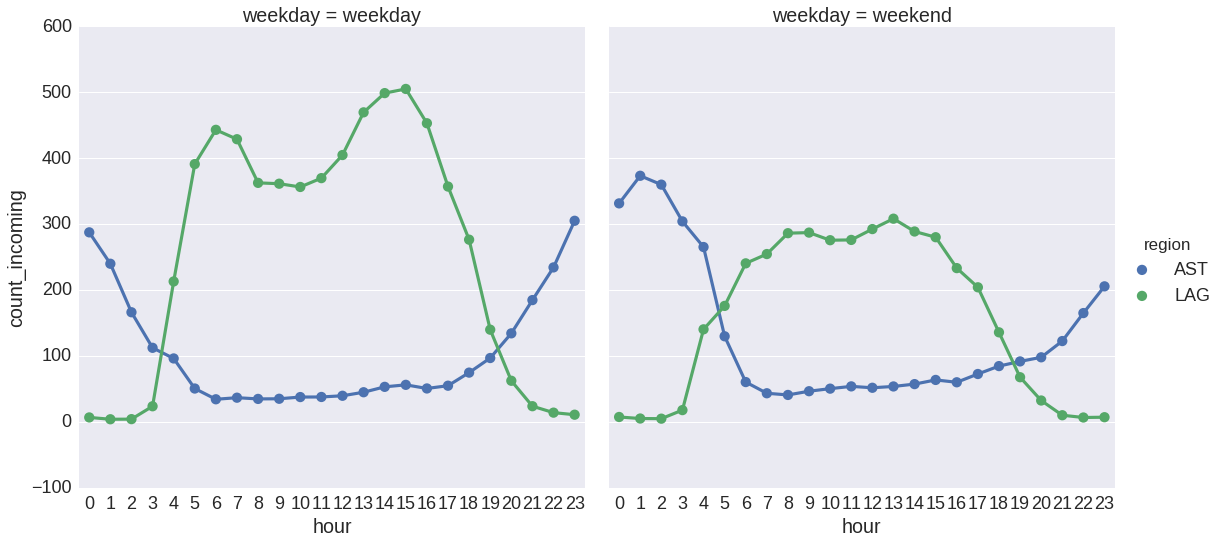

In [30]:
sns.set(font_scale=1.8)

g = sns.factorplot(x='hour',y='count_incoming', col="weekday",
               data=agg_flow[agg_flow.region.isin(["AST", "LAG"])],
               hue='region', size=8)
print("number of rides coming in at different hours of the day")

number of rides going out at different hours of the day


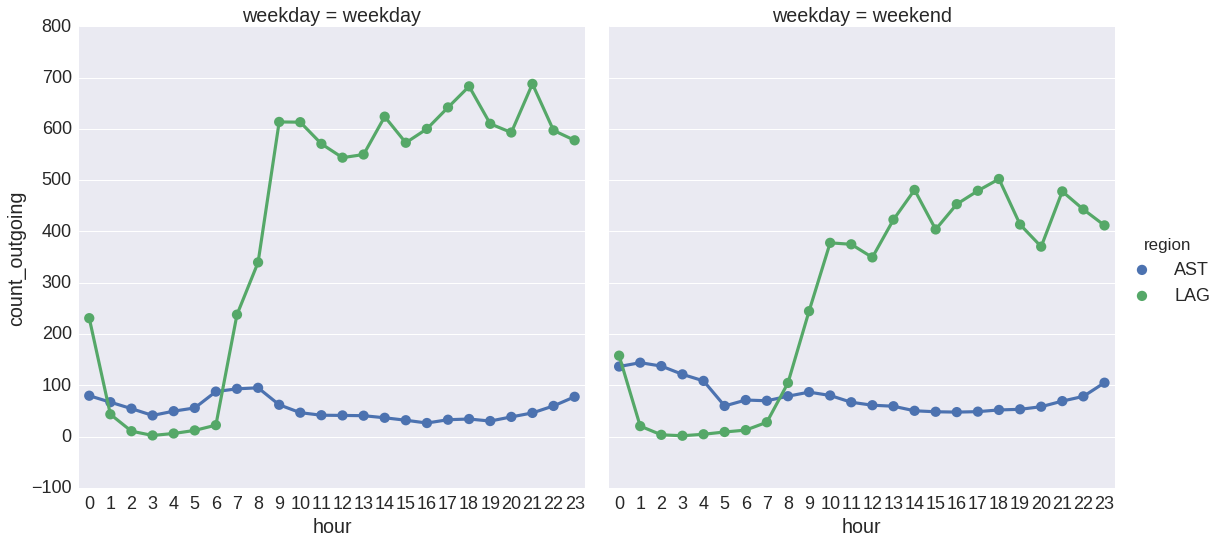

In [31]:
g = sns.factorplot(x='hour', y='count_outgoing', col="weekday",
               data=agg_flow[agg_flow.region.isin(["AST", "LAG"])],
               hue='region', size=8)
plt.yticks(rotation=15)
print("number of rides going out at different hours of the day")

This is even clearer when we plot the difference between incoming and outgoing rides in these two areas: The sign of the two curves are opposite for most of the time. This means the drivers taking passengers to Astoria can later go to LaGuardia airport and pick up their next passengers when they can not find one in Astoria! Anyway, driving from Astoria to LaGuardia will only take them about 10 minutes.

(# rides coming in - # rides going out) at different hour of the day


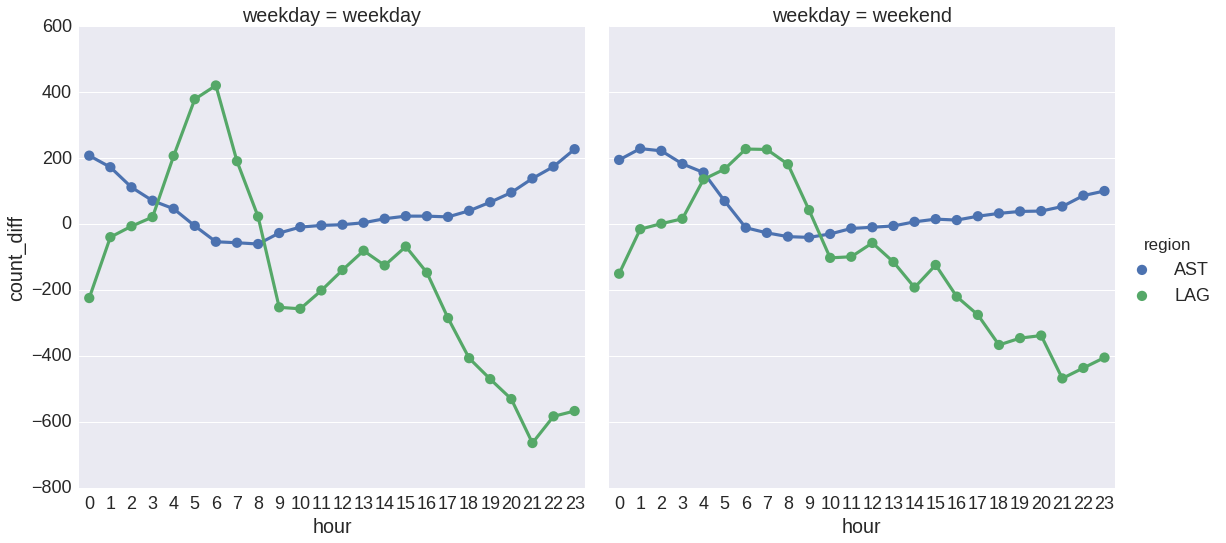

In [32]:
sns.factorplot(x='hour',y='count_diff', col="weekday",
               data=agg_flow[agg_flow.region.isin(["AST", "LAG"])],
               hue='region', size=8)
plt.yticks(rotation=15)
print("(# rides coming in - # rides going out) at different hour of the day")

### B) Improve efficiency by ride-sharing <a id="chapter-3b"></a>

Another way to improve the current efficiency is to introduce ride-sharing between passengers. Providing ride-sharing services can help passengers to reduce cost and also reduce the number of drivers needed in this area. 

However since there's not enough data and time, I will save this part of analysis for the future.

## 4. Statistical Questions <a id="chapter-4"></a>

### A) How to determine whether a zone is more efficient than the rest of the city? How to determine why it's more efficient? <a id="chapter-4a"></a>

#### Is the efficiency in a zone higher than the rest?
If given a efficiency metric $E$ (we don't know how it has been calculated) for each zone in the city, we want to find out whether one particular zone A is more efficient than the rest of zones (B, C, D, etc.) in the city. Our null hypothesis in this case is the efficiency $E_A$ is equal with the population mean of efficiency $E$ from all the zones. $H_0: E_A = \mu_E$. The alternative hypothesis is that the efficiency in zone A is higher than the population mean. $H_A: E_A > \mu_E$. Assuming the distribution of efficiency are normal and efficiency scores for each zone are independent random sample from the whole population, we can set a significance level $\alpha$ and perform a **one-tailed t-test** to test the hypothesis. If the p-value calculated is lower than $\alpha$ we can reject the null hypothesis and claim that the efficiency in this zone is higher than the rest of the city with $1-\alpha$ confidence.

#### How to determine why it's more efficient?
Since we don't know how the efficiency metric is calculated, we need to collect all possible features for different zones and try to find some relevant feature to explain the efficiency. The **features** we can think about include the region's population, area, borough, whether it is a residential/commercial area, the residence's demographical information, different types of building and other common facilities in this area, public transportation information, etc.

To understand which features are the reasons for the efficiency, we can **build a predictive model (e.g. a linear regression or a random forest)** to use these features as inputs and predict the efficiency score as output. From the model, we can get the feature importance in explaining the output. **For linear regression, the importance can be represented by the coefficents for each feature. While for random forest, the importance of features can be calculated by how much this feature helps to reduce the sum of square error in the model.**

### B) How to compare distributions of intra-city trip prices between different cities? How to test whether differences are explained by distance and duration? <a id="chapter-4b"></a>

#### How to compare two distributions of trip prices?
The distribution of trip prices is not a normal distribution since it will be a **highly right skewed distribution that peaks at a small value but with a much longer tail**. For non-Gaussian distributions, we need to perform some **non-parametric test** to determine whether the two distributions are the sane. I will perform a **Mann-Whitney U test** (also called a Wilcoxon rank-sum test) to compare the two price distributions. The null hypothesis here is the two distributions of trip prices are both simple random samples from the same population, while the alternative hypothesis is that the two distributions are not the same. By setting a significance level $\alpha$ and comparing the U statistics with the critical value, if U is less or equal than the critical value we can reject the null hypothesis and claim there's a difference in the two distributions with confidence $1-\alpha$.

#### How to test whether differences are explained by distance and duration?
In order to find out whether the different trip prices are due to distance and durations, we can set the price as the response variable and the distance and durations as explanatory variables and perform a ** linear regression** to find out the **coefficient of determination $R^2$ score**. $R^2$ is the proportion of variance in the response variable (trip price) that can be explained by the explanatory variables (distance and duration).

## 5. Conclusions and Insights <a id="chapter-5"></a>

In this data challenge, we performed analysis on the NYC taxi data to help us decide whether we want to launch new via services in Astoria, Queens. The main conclusions from this analysis are:
  * The current taxi efficiency in Astoria is low compared to our current service area Upper East Side in Manhattan
  * There are more demand in rides between Astoria and Manhattan compared to only within Astoria
  * It is reasonable to launch services 24/7 between Astoria and Manhattan with the help of via software to recommend next pickup for drivers and recommend ride-sharing options for passengers
  * With the help of via platform (ride-sharing and pickup recommendations), the efficiency of the transportation system in Astoria can be significantly improved 